# Эксперимент с загрузкой, обработкой и выгрузкой данных в JSON формате в PostgreSQL с использованием Python.

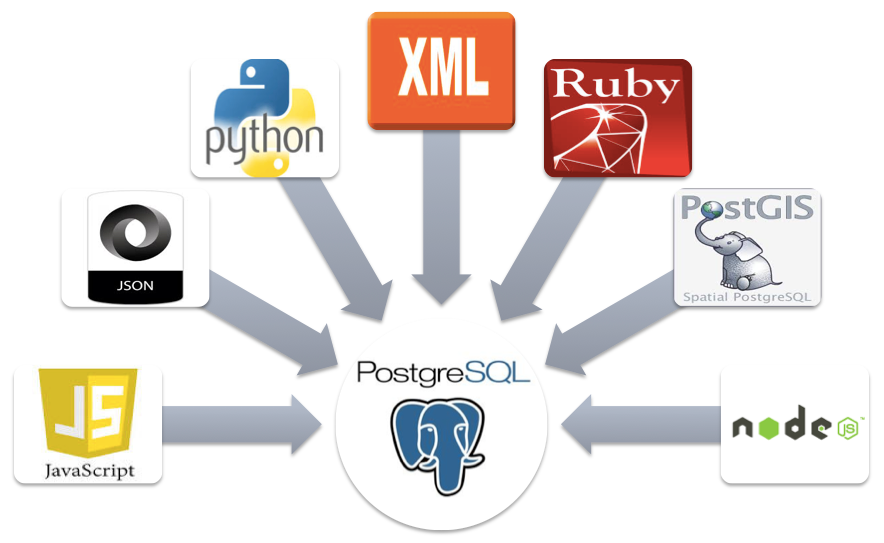

## Постановка задачи

Отвлекусь  на время от рутинного экспорта данных в pandas из Excel или  CSV и представим себе  сервер приложений,  который получает  по REST  API  через POST   данные от каких то клиентских устройств в JSON  формате имеющие следующий вид:

`{
"user_id": 37574289, 
"x_date": "2021-10-14",
 "x_arr": [0.16935019616704988, 0.6318375641063588, -0.9873405379685942, -1.8143850971735889, 0.06967929388957042, 0.8964275162395873, 0.054862970488850415, -0.5725337838209879, -0.3884557042792029, -0.2112704984585462, -1.7237536316322168], 
"y_date": "2020-11-13", 
"y_arr": [1.30670272379225, -0.4458001600667661, 0.9178922489672809, 0.5728364202483521, 0.8792511712630854, 0.010695785350633983, -1.2492542389229544, -1.3417938780795458, 1.2051559717065756, -0.6020604610098743]
}`

для дальнейшего сохранения в базе данных.  

Даты и размерность массивов данных для `x` и `y` могут быть одинаковыми, а могут быть и разными. В случае одинаковых  дат и размерности массива данных для `x` и `y` надо вычислить `Pearson correlation` coefficient and `p-value` for testing non-correlation и добавить эти значения в пришедший  из фронта JSON, в случае  же разных дат и размерностей массива данных для `x` и `y` никаких вычислений не производится. После анализа и возможного добавления Pearson correlation и p-value   данные из пришедшего из фронта  JSON сохраняются   в базе данных сервера приложений.

В случае же получения запроса GET со стороны фронта  от клиентского устройства из пришедшего JSON извлекается `user_id` и делается запрос в базу данных. 

В случае если значения   `Pearson correlation`  и `p-value` не `NULL` у  строки с  `user_id` из запроса то сервер для response = 200 выгружает   JSON  со следующими данными:

`{"user_id": 611507223, 
"x_date": "2021-11-29", 
"x.arr": [0.49751510255206216, 0.09340760630980574, -0.6014951947000469, 0.5571189102362565, -1.0282770381484858, 0.713152845525601, -0.2161634171110876, -0.6751099847391324, 0.8084208557584655, 1.5990206947421133], "y_date": "2021-11-29", 
"y_arr": [-1.3858716699962381, 2.6560838358751906, -3.4943038213314477, -0.6540470006777962, 1.307777839595926, 3.229699840082391, -2.209640527291255, 1.0898657725520906, -0.3033557783682296, 2.282817821254299], 
"pearson": 0.30615723, 
"p_val": 0.38960373}
`
В случае если же строка `user_id` содержит `NULL` значения для `Pearson correlation`  и `p-value` то в сторону фронта сервер выдает следующий JSON c кодом response=404:

`{"error": "The requested resource was not found."}`

По условиям задачи язык разработки приложения — Python, сервер баз данных выбирается самостоятельно.  



## Выбор базы данных  и создание

В качестве open source базы данных мною был выбран `Postgresql` из за большого количества поддерживаемых ей типов данных — массивы, JSON и т.п.
На сервере создается база данных `observ_db` c таблицей `observ_log`, view `observations`  и datatype `json_temp_row`. 

In [1]:
import copy
import json
import numpy as np
import pandas as pd
import psycopg2

from random import seed
from random import gauss
from random import randint
from random import shuffle

from scipy import stats

from sqlalchemy import MetaData
from sqlalchemy import inspect, create_engine

from time import perf_counter
# =============================================================================
# 1. Create new  database and new table
# Define connections for creating database, table, view and data type for 
# convert JSONs to DML script
# =============================================================================
log_to_psql = "host=localhost port = 5432 user=postgres \
password=change_to_yours"
log_to_psql_db = log_to_psql +" dbname = observ_db"

# Define DDL scripts for new database and table
sql_create_db = """
CREATE DATABASE observ_db
    WITH 
    OWNER = postgres
    ENCODING = 'UTF8'
    LC_COLLATE = 'en_US.UTF-8'
    LC_CTYPE = 'en_US.UTF-8'
    TABLESPACE = pg_default
    CONNECTION LIMIT = -1;
    """

sql_create_table = """
CREATE TABLE public.observ_log (
    obs_id bigserial NOT NULL,
    user_id int8 NOT NULL,
    x_date date NOT NULL,
    x_arr _float8 NOT NULL,
    y_date date NOT NULL,
    y_arr _float8 NOT NULL,
    pearson float4 NULL,
    p_val float4 NULL,
    CONSTRAINT observ_log_pk PRIMARY KEY (obs_id),
    CONSTRAINT user_x_date UNIQUE (user_id, x_date),
    CONSTRAINT user_y_date UNIQUE (user_id, y_date));
"""

sql_create_view = """
create view observations as
    select * from observ_log;
"""

sql_create_data_type = """
create type json_temp_row as (
    user_id int8,  x_date date, x_arr _float8, 
    y_date date, y_arr _float8, pearson float8, 
    p_val float8);
"""


def ddl_ddm_ins(logstring, ddl_string):
    """
    Function for Data Definition Manupulation

    Parameters
    ----------
    logstring : string
        String for connecting requered database or table.
    ddl_string : string
        SQL script for DDL.
    Returns
    -------
    None.
    """
    conn = psycopg2.connect(logstring)
    conn.set_session(readonly=False, autocommit=True)
    cur = conn.cursor()
    # DDL of DDM manilpulation
    cur.execute(ddl_string)
    # close session and cursor
    cur.close()
    conn.close()


# Create observ_db database
ddl_ddm_ins(log_to_psql, sql_create_db)

# Create observ_log table
ddl_ddm_ins(log_to_psql_db, sql_create_table)

# Create view observations for observ_log table
ddl_ddm_ins(log_to_psql_db, sql_create_view)

# Create datatype for converting JSONs to SQL query
ddl_ddm_ins(log_to_psql_db, sql_create_data_type)


## Генерация данных с фронта, их обработка и занесение в базу

Данные в количестве 10 тыс строк генерируются рандомно, половина данных имеет отличные от NULL значения `Pearson correlation`  и `p-value`, другая половина имеет NULL   NULL значения `Pearson correlation`  и `p-value`.  Данные из JSON формата конвертируются в требуемые значения  отдельных  столбцов таблицы `observ_log` с целью увеличения скорости возможного поиска. Я не закидываю JSON  в  таблицу  виде отдельного столбца с типом данных JSON, а провожу декомпозицию  JSON и заношу данные из него в отдельные столбцы. Исходим из допущения что устройства посылают итоговые данные за день, поэтому в таблице `observ_log` стоит ограничение в виде уникального сочетания `user_id` и даты наблюдения `x` и `y`.

In [2]:
# =============================================================================
# 2. Emulate, calculate required values for  JSONs input  data and inserting 
# preprocessing JSON values to crated early database
# =============================================================================

time_start = perf_counter()
# Emulate input JSONs function
def json_post_random(samples_no, denominator = 2):
    """
    Generate random JSON for further using
    Parameters
    ----------
    samples_no : integer
        Number of generated samples.
    denominator : integer, optional
        DESCRIPTION. JSON having same date and x and 
        y array dimensions to all number having reminder equal zero  when 
        it divide to denominator.
    Returns
    -------
    json_lst : random shuffle List of  JSONs.
        DESCRIPTION.
    """
    samples = samples_no
    seed(1)
    json_lst = []
    for i in range(samples):
        # generate json with calculated pearson values
        jsn_tmpl = {"user_id": None , "x_date": None , 
                   "x_arr": None, "y_date": None , "y_arr": None}
        if divmod(i, denominator)[1] == 0:
            user_id = randint(1000000, 1000000000)
            x_date =  str(randint(2020, 2021)) + "-" + str(randint(10,12))\
                + "-" + str(randint(10,30))
            x_arr = [gauss(0,1) for i in range(10)]
            y_date = x_date
            y_arr = [gauss(0,2) for i in range(10)]
            dic_vals = [user_id, x_date, x_arr, y_date, y_arr]
            for i, key in enumerate(jsn_tmpl.keys()):
                jsn_tmpl[key]=dic_vals[i]
        else:
            user_id = randint(1000000, 1000000000)
            x_date =  str(randint(2020, 2021)) + "-" + str(randint(10,12))\
                + "-" + str(randint(10,30))
            x_arr = [gauss(0,1) for i in range(randint(8,15))]
            y_date = str(randint(2020, 2021)) + "-" + str(randint(10,12))\
                + "-" + str(randint(10,30))
            y_arr = [gauss(0,1) for i in range(randint(8,15))]
            dic_vals = [user_id, x_date, x_arr, y_date, y_arr]
            for i, key in enumerate(jsn_tmpl.keys()):
                jsn_tmpl[key]=dic_vals[i]
        jsn = json.dumps(jsn_tmpl)
        json_lst.append(jsn)
    
    shuffle(json_lst)
    return json_lst

# Generate random JSON list
jsn_post_raw = json_post_random(10000)

# Calculate Pearson correlation  and p-val and add its # values to input JSONs
# function 

def json_post_calc(json_str):
    """
    Add pearson and p-values for JSONs that have same date and length of list.
    For JSONs that have different date and length of list add None values for 
    keys `pearson` and `p_val`
    Parameters
    ----------
    json_str :  The JSON format string 
        DESCRIPTION.
    Returns
    -------
    jsn : TYPE
        DESCRIPTION.

    """
    jsn_test = copy.deepcopy(json_str)
    jsn_dic = json.loads(jsn_test)
    add_keys = ["pearson", "p_val"]
    for key in add_keys:
        jsn_dic.update({key:None})
    
    if (jsn_dic['x_date'] == jsn_dic['y_date'] and  
        len(jsn_dic['x_arr']) == len(jsn_dic['y_arr'])):
        jsn_dic["pearson"], jsn_dic["p_val"]  = stats.pearsonr(
            np.array(jsn_dic["x_arr"]), np.array(jsn_dic["y_arr"])
            )
    jsn = json.dumps(jsn_dic)
    return jsn


# Calculate Pearson and p-value for input JSONs  
jsn_post_ins = [json_post_calc(jsn_post_raw[i]) for i in range(len(jsn_post_raw))]

# Converting JSON to sql insert into statement function
def post_to_sql_insert(post_json):
    ins_conv_jsn = """
    insert into observ_log 
        (user_id, x_date, x_arr, y_date, y_arr, pearson, p_val)
    (select * from json_populate_record(null::json_temp_row,'{}'))""".\
    format(post_json)
    ddl_ddm_ins(log_to_psql_db, ins_conv_jsn)


# Insert data from calculaterd JSONs to database obesrv_log

ins_rec = 0
for jsn in jsn_post_ins:
    post_to_sql_insert(jsn)
    ins_rec +=1
    

time_end = perf_counter()
time_exec = divmod((time_end - time_start), 60) 
print("Time for  generating and inserting {}  recodrs into  observ_log table - \
{:.0f} min {:.4f} sec.".format(ins_rec, time_exec[0], time_exec[1]))

Time for  generating and inserting 10000  recodrs into  observ_log table - 4 min 7.5949 sec.


## Просмотр внесенных данных

В качестве просмотрщика внесенных данных используется pandas, SQL Alchemy и метод pd.read_sql_table который корректно отображает значения числовом и временном формате, автоматом конвертирует NULL в NaN — так как другие методы преобразования данных их SQL запроса в pandas требуют потом много лишней  работы ручками по преобразованию одного  типа данных в другой к примеру `None` в `NaN`, `object` в `datetime64`и т.д и т.п.

In [3]:
from IPython.display import HTML
pd.set_option('display.max_columns', None)

db = {'name': 'observ_db', 'user': 'postgres', 'password': 'change_to_yours',
        'host': 'localhost', 'port': 5432}

engine_str = "postgresql+psycopg2://{user}:\
{password}@{host}:{port}/{database}".format(
    user = db['user'],
    password = db['password'],
    host = db['host'],
    port = db['port'],
    database = db['name'])

engine = create_engine(engine_str)
engine_insp  = inspect(engine) 
metadata = MetaData()
metadata.reflect(bind=engine, views = True)
view_data_df = pd.read_sql_table('observations', engine)
view_data_df.head(12)

,obs_id,user_id,x_date,x_arr,y_date,y_arr,pearson,p_val
0,1,37574289,2021-10-14,"[0.16935019616704988, 0.6318375641063588, -0.9...",2020-11-13,"[1.30670272379225, -0.4458001600667661, 0.9178...",NaN,NaN
1,2,315277555,2020-11-24,"[0.11658987514441373, 1.3776463095864142, -0.1...",2021-10-14,"[-0.43839013002736515, -0.3680405232635006, 0....",NaN,NaN
2,3,679522495,2021-10-29,"[-0.35851214774349877, 0.34797021955515156, 1....",2021-10-29,"[2.018654747262441, -4.25715271835406, 1.15799...",0.103863,0.775235
3,4,532472204,2021-11-14,"[1.4319916793148744, 1.315965364740652, -0.737...",2021-11-14,"[-2.7656770425678925, 0.815346450027795, 1.838...",-0.266060,0.457473
4,5,61611869,2021-10-16,"[-0.7344594902017454, -1.7292153840623488, -1....",2020-10-18,"[0.8082077941038825, 1.7754739506999513, 0.767...",NaN,NaN
5,6,657032295,2020-11-29,"[-1.4184159204472844, -1.8165915936078922, 0.4...",2020-11-29,"[0.679119089576024, 0.8873744397603525, -3.823...",-0.667626,0.034907
6,7,854613495,2020-10-11,"[0.11250509401549182, 1.7238085565854495, -0.6...",2020-10-11,"[0.6864778480816722, 0.6412405021319241, -0.36...",0.267446,0.455042
7,8,869389004,2020-12-18,"[0.28930716159938624, 1.7146814860144044, 0.60...",2020-12-18,"[-1.0133639436999964, 0.5040584884664159, -1.6...",-0.548069,0.100962
8,9,638473927,2020-10-24,"[0.5443975327413931, -0.3180865514742698, 1.13...",2021-12-13,"[1.1852141054185015, 0.9315125664733089, 0.730...",NaN,NaN
9,10,541453235,2020-11-26,"[1.1119002672580676, 0.9580831181514778, -0.13...",2020-11-26,"[2.5576877189798095, -1.9773577993862863, -1.7...",-0.010585,0.976848


In [4]:
view_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   obs_id   10000 non-null  int64         
 1   user_id  10000 non-null  int64         
 2   x_date   10000 non-null  datetime64[ns]
 3   x_arr    10000 non-null  object        
 4   y_date   10000 non-null  datetime64[ns]
 5   y_arr    10000 non-null  object        
 6   pearson  5008 non-null   float64       
 7   p_val    5008 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 625.1+ KB


# Выдача требуемого JSON на запрос фронта

Ниже приведен код эмуляции для  выгрузки из базы данных JSON для запроса по существующему в базе `user_id`  с NOTNULL  - `user_right_jsn`  и NULL - `user_wrong_jsn`  значениями `Pearson correlation`  и `p-value`

In [5]:
# =============================================================================
# 4. Extract data from database and  convert to JSON  and prepare its for
# deployng
# =============================================================================

# define users  for extract rundom data with and with out 
# not null value for pearson
user_pears_not_null = view_data_df[~view_data_df.pearson.isna()].user_id.values
user_pears_null = view_data_df[view_data_df.pearson.isna()].user_id.values

user_right_get = np.random.choice(user_pears_not_null)
user_wrong_get = np.random.choice(user_pears_null)

# Generate json for user with  pearson and p_val values
def get_user_response(user_id):
    """
    Return JSON for earch users_is in the table, 
    if pearson and p_val not null - json for response status 200, if NULL - 
    response status 404.
    Parameters
    ----------
    user_id : int.

    Returns
    -------
    response_json : json object
    """
    sql_query_row_to_json = """
    select json_build_object 
    (
        'user_id', ol.user_id, 	'x_date', ol.x_date, 'x.arr', ol.x_arr, 
        'y_date', ol.y_date, 'y_arr', ol.y_arr, 'pearson', ol.pearson,
    	'p_val', ol.p_val 
    )  as json_str
    from observ_log as ol
    where ol.user_id = {}
    group by ol.obs_id ;
    """.format(user_id)
    conn = psycopg2.connect(log_to_psql_db)
    cur = conn.cursor()
    cur.execute(sql_query_row_to_json)
    
    cur_dic = cur.fetchall()[0][0]
    requests_404 = {"error": "The requested resource was not found."}
    
    if  isinstance(cur_dic["pearson"], float) and \
        isinstance(cur_dic["p_val"], float):
            response_dic = cur_dic
    else:
        response_dic = requests_404
    
    response_json = json.dumps(response_dic)
    return response_json

user_right_jsn = get_user_response(user_right_get)
user_wrong_jsn = get_user_response(user_wrong_get)
print('user right json\n', user_right_jsn)
print('\nuser wrong json\n', user_wrong_jsn)

user right json
 {"user_id": 275124169, "x_date": "2020-10-28", "x.arr": [0.24683465747724206, -1.012268043871076, 0.8378785137310405, -0.8754710821935738, 2.5873982283492385, -1.08188760510858, 0.7581796012437104, 0.9776825241370379, -1.7960389916613104, 1.225664842371517], "y_date": "2020-10-28", "y_arr": [-1.6136245780219938, -3.435998633546702, 1.8405474338573347, 0.5016545633024535, 1.149577174553902, -0.21397738959531387, 0.8016287204048379, -2.2596427031957913, -0.9119651083818672, 0.5630029557077484], "pearson": 0.43445668, "p_val": 0.20960888}

user wrong json
 {"error": "The requested resource was not found."}


## Заключение

1. PostgreSQL  - база данных с большим набором поддерживаемых типов данных и набором функций для их обработки.


2. В связи с тем, что Docker фактически находится при смерти в настоящий момент,  и тем что данная задача требует не большого  количества  простых пакетов (без каких либо сложных зависимостей подобных Tensorflow) данный ноутбук без проблем будет исполнятся на локальном компьютере в среде с  PostgreSQL 14.1 и Python  cо следующими  установленными пакетами:


* SQLAlchemy                        1.4.29
* psycopg2-binary                   2.9.3 
* scipy                             1.7.3
* pandas                            1.3.5
* numpy                             1.19.5

P.S. Не забудьте сменить пароли и имена пользователей базы данных в случае проверки работоспособности ноутбука.

Created on January 13, 2022

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: Debian 10, Python 3.8.12(compiled from source Clang-12)

See required installed and imported python modules in the cell No 1.